### About Dataset

This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions.


- id: listing ID
- name: name of the listing
- host_id: host ID
- host_name: name of the host
- neighbourhood_group: location
- neighbourhood: area
- latitude: latitude coordinates
- longitude: longitude coordinates
- room_type: listing space type
- price: price in dollars
- minimum_nights: amount of nights minimum
- number_of_reviews: number of reviews
- last_review: latest review
- reviews_per_month: number of reviews per month
- calculated_host_listings_count: amount of listing per host
- availability_365: number of days when listing is available for booking

#### Acknowledgements

This public dataset is part of Airbnb, and the original source can be found on this [website](https://insideairbnb.com/get-the-data/).

In [1]:
!python -V

Python 3.12.5


### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

import folium
from folium.plugins import HeatMap
from ipywidgets import interact, widgets

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [4]:
df = pd.read_csv("../datasets/airbnb-listings-may.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,1489424,"Welcoming, easygoing, comfy bed, entire level",5294164,Efrat,NaN,FOURTEENTH WARD,42.66719,-73.81580,Private room,50.0,1,250,2024-04-21,1.93,1,255,48,NaN
1,2992450,Luxury 2 bedroom apartment,4621559,Kenneth,NaN,THIRD WARD,42.65789,-73.75370,Entire home/apt,NaN,28,9,2022-08-17,0.08,1,36,0,NaN
2,3820211,Restored Precinct in Center Sq. w/Parking,19648678,Terra,NaN,SIXTH WARD,42.65222,-73.76724,Entire home/apt,118.0,2,300,2024-04-28,2.53,4,361,15,NaN
3,5651579,Large studio apt by Capital Center & ESP@,29288920,Gregg,NaN,SECOND WARD,42.64615,-73.75966,Entire home/apt,90.0,1,343,2024-04-21,3.13,2,15,28,NaN
4,6623339,Center Sq. Loft in Converted Precinct w/ Parking,19648678,Terra,NaN,SIXTH WARD,42.65222,-73.76724,Entire home/apt,120.0,2,314,2024-04-27,2.89,4,357,11,NaN


In [5]:
df.shape

(394, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              394 non-null    int64  
 1   name                            394 non-null    object 
 2   host_id                         394 non-null    int64  
 3   host_name                       394 non-null    object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   394 non-null    object 
 6   latitude                        394 non-null    float64
 7   longitude                       394 non-null    float64
 8   room_type                       394 non-null    object 
 9   price                           344 non-null    float64
 10  minimum_nights                  394 non-null    int64  
 11  number_of_reviews               394 non-null    int64  
 12  last_review                     349 

In [7]:
df.isnull().sum()

id                                  0
name                                0
host_id                             0
host_name                           0
neighbourhood_group               394
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                              50
minimum_nights                      0
number_of_reviews                   0
last_review                        45
reviews_per_month                  45
calculated_host_listings_count      0
availability_365                    0
number_of_reviews_ltm               0
license                           394
dtype: int64

In [8]:
# Handling missing values
df = df.dropna(subset=['price'])
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['last_review'] = pd.to_datetime(df['last_review'])

In [9]:
df.isnull().sum()

id                                  0
name                                0
host_id                             0
host_name                           0
neighbourhood_group               344
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                               0
minimum_nights                      0
number_of_reviews                   0
last_review                        31
reviews_per_month                   0
calculated_host_listings_count      0
availability_365                    0
number_of_reviews_ltm               0
license                           344
dtype: int64

In [10]:
# Identify categorical and numerical variables
categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical = df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Variables:", categorical)
print("Numerical Variables:", numerical)

Categorical Variables: ['name', 'host_name', 'neighbourhood', 'room_type']
Numerical Variables: ['id', 'host_id', 'neighbourhood_group', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']


In [11]:
# Select relevant columns for modeling
features = ['room_type', 'neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'price']
df = df[features]

#### Visualizing Price Distribution

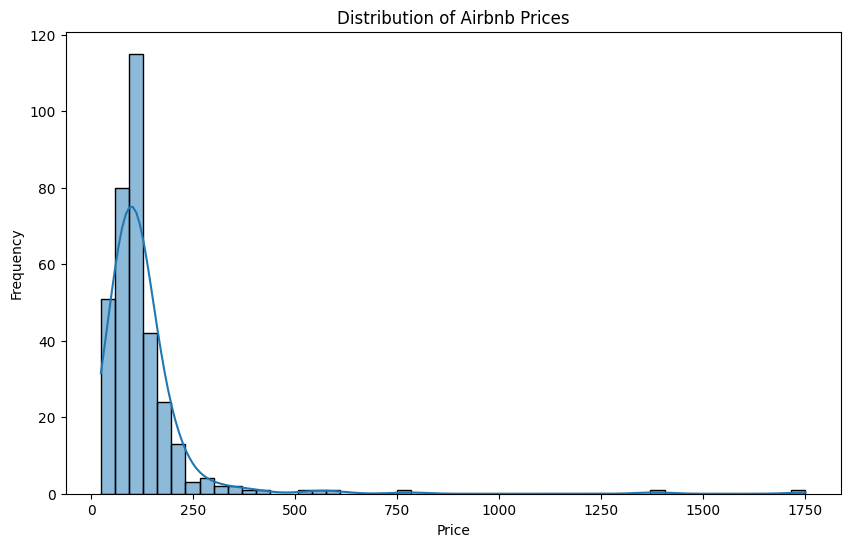

In [12]:
# Distribution of Airbnb Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [13]:
skewness = df['price'].skew()
print(f"Skewness: {skewness}")

Skewness: 7.792385461214022


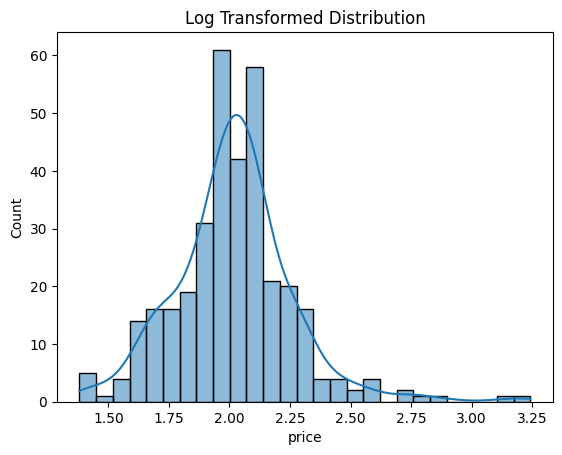

In [14]:
# Apply a log10 transformation to the target column
# log10(x) computes log base 10 of x
df['price'] = np.log10(df['price'])

sns.histplot(df['price'], kde=True)
plt.title('Log Transformed Distribution')
plt.show()

In [15]:
skewness = df['price'].skew()
print(f"Skewness after log transformation: {skewness}")

Skewness after log transformation: 0.7656451898531771


#### Outlier detection

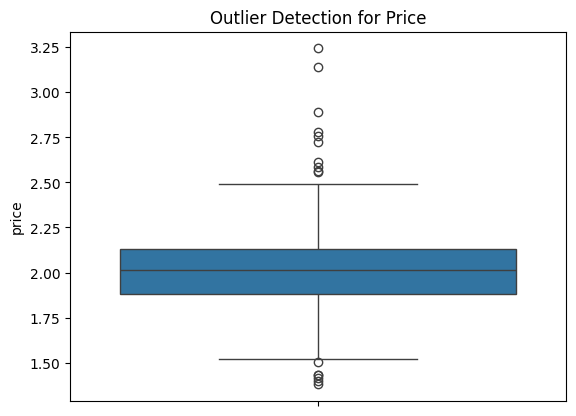

In [16]:
# Visualize the price column
sns.boxplot(df['price'])
plt.title('Outlier Detection for Price')
plt.show()

In [17]:
# Calculate IQR
Q1 = df['price'].quantile(0.25)  # First quartile (25th percentile)
Q3 = df['price'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Outliers:\n", outliers)

# Remove outliers
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].reset_index(drop=True)

Outliers:
            room_type    neighbourhood   latitude  longitude  minimum_nights  \
10   Entire home/apt   FIFTEENTH WARD  42.675670 -73.824380               1   
30   Entire home/apt   FIFTEENTH WARD  42.675470 -73.824020               4   
123  Entire home/apt       TENTH WARD  42.662360 -73.792450               2   
133  Entire home/apt   FIFTEENTH WARD  42.674675 -73.822861               1   
161  Entire home/apt  FOURTEENTH WARD  42.667620 -73.799190               1   
199     Private room  FOURTEENTH WARD  42.660080 -73.798160              30   
200     Private room  FOURTEENTH WARD  42.659297 -73.797201              30   
201     Private room  FOURTEENTH WARD  42.659359 -73.797269              30   
237     Private room       NINTH WARD  42.656329 -73.775205               1   
257  Entire home/apt       FIRST WARD  42.635040 -73.798330               2   
303  Entire home/apt       TENTH WARD  42.660363 -73.772902               1   
333  Entire home/apt      EIGHTH WARD  42

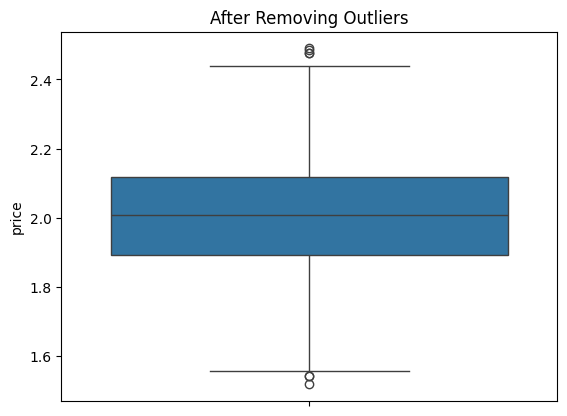

Cleaned Data:
            room_type    neighbourhood   latitude  longitude  minimum_nights  \
0       Private room  FOURTEENTH WARD  42.667190 -73.815800               1   
1    Entire home/apt       SIXTH WARD  42.652220 -73.767240               2   
2    Entire home/apt      SECOND WARD  42.646150 -73.759660               1   
3    Entire home/apt       SIXTH WARD  42.652220 -73.767240               2   
4       Private room       TENTH WARD  42.660630 -73.781150               3   
..               ...              ...        ...        ...             ...   
323  Entire home/apt  THIRTEENTH WARD  42.671052 -73.799501               5   
324     Private room       NINTH WARD  42.661427 -73.792143               1   
325  Entire home/apt       SIXTH WARD  42.652492 -73.767436               1   
326     Private room    ELEVENTH WARD  42.662590 -73.773300               2   
327  Entire home/apt       SIXTH WARD  42.652736 -73.767787               1   

     number_of_reviews  reviews_per_

In [18]:
# Visualize cleaned data
sns.boxplot(df['price'])
plt.title('After Removing Outliers')
plt.show()

# Check the cleaned dataframe
print("Cleaned Data:\n", df)

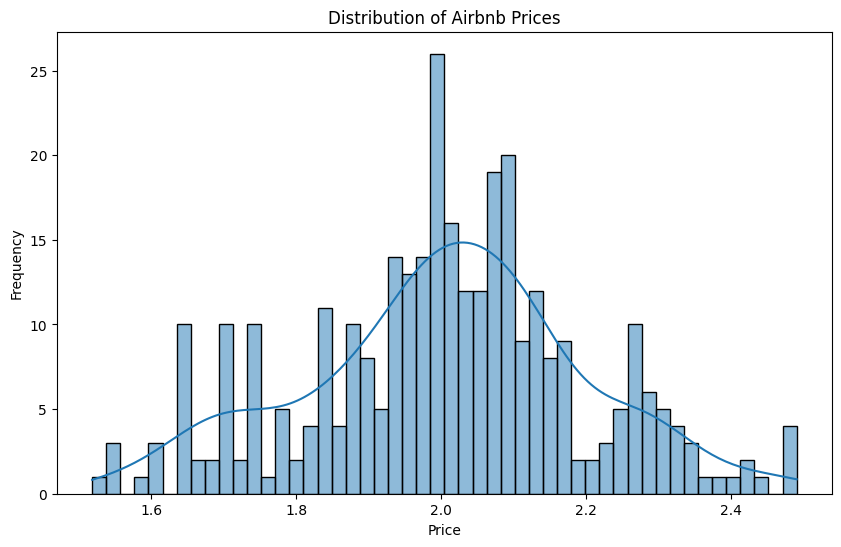

In [19]:
# Distribution of Airbnb Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

#### Visualizing Geographical Data with a Heatmap

In [20]:
# Create a base map centered in New York City
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add a heatmap layer
heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(map_nyc)

map_nyc

### Exploratory Data Analysis


In [24]:
numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
categorical = ['room_type', 'neighbourhood']
target = ['price']

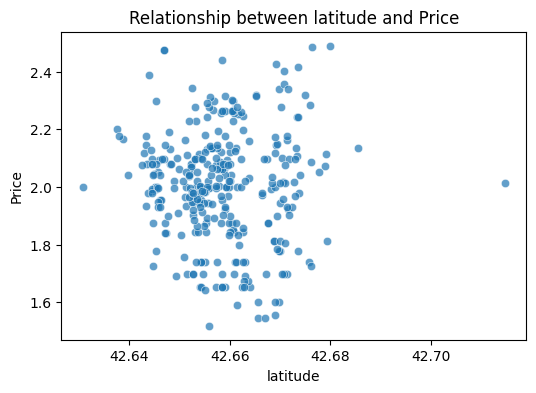

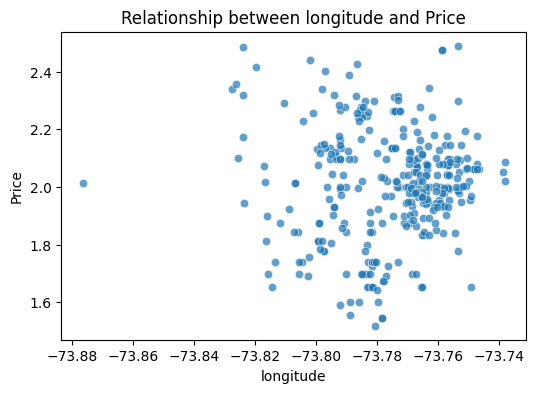

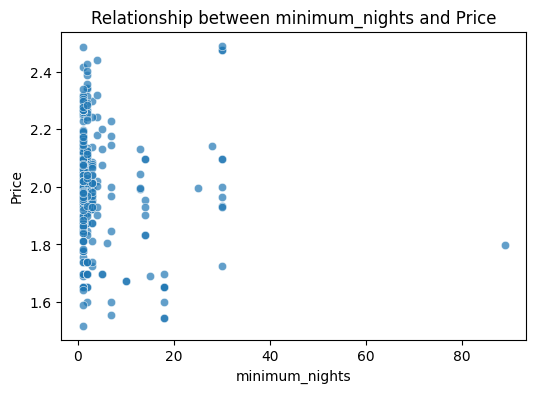

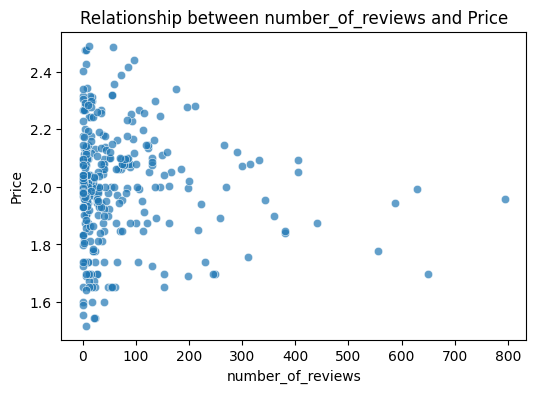

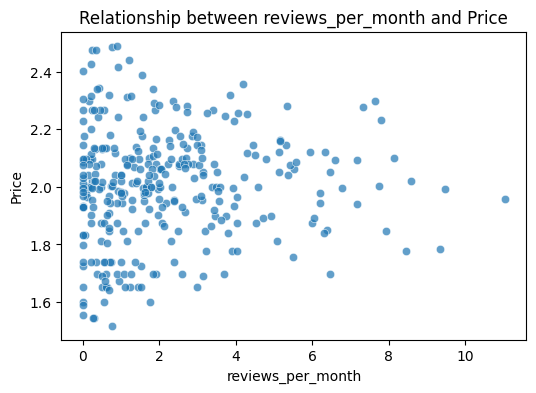

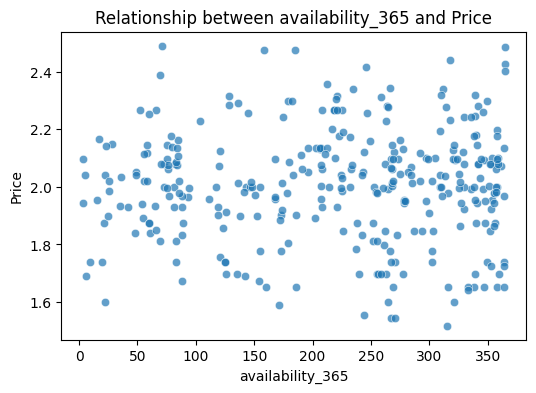

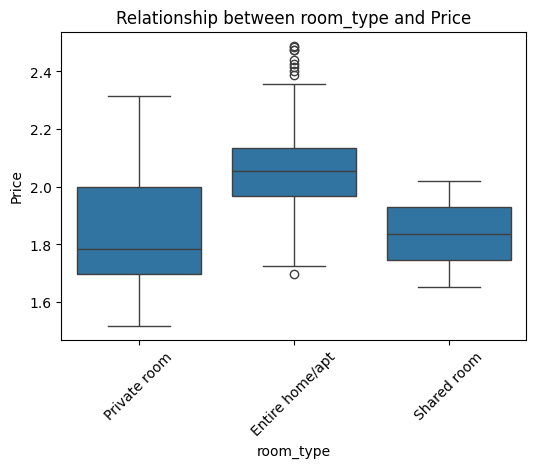

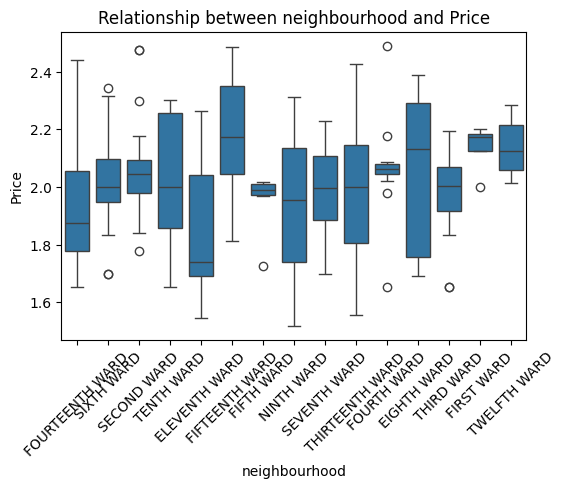

In [25]:
# Relationship of numerical variables with price
for col in numerical:
    plt.figure(figsize=(6, 4), dpi=100)
    sns.scatterplot(data=df, x=col, y='price', alpha=0.7)
    plt.title(f'Relationship between {col} and Price')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

# Relationship of categorical variables with price
for col in categorical:
    plt.figure(figsize=(6, 4), dpi=100)
    sns.boxplot(data=df, x=col, y='price')
    plt.title(f'Relationship between {col} and Price')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.show()

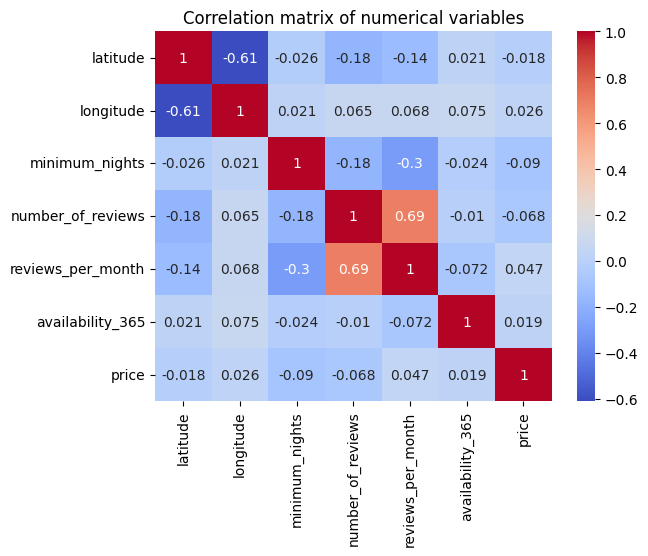

In [26]:
correlation_matrix = df[numerical + target].corr()

# plt.figure(figsize=(20,10))
title = 'Correlation matrix of numerical variables'
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title(title)
plt.show()

In [27]:
# Extract correlation with price
correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
correlation_with_price

price                1.000000
reviews_per_month    0.046715
longitude            0.026008
availability_365     0.019328
latitude            -0.017702
number_of_reviews   -0.068294
minimum_nights      -0.090271
Name: price, dtype: float64

#### Room type

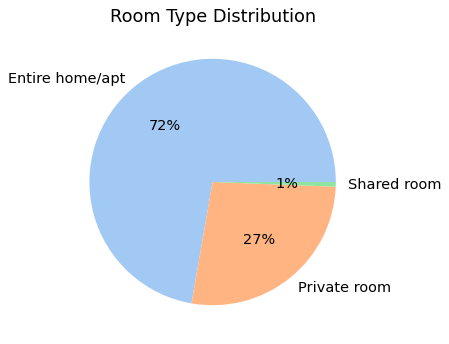

In [28]:
# Count the occurrences of each room type
room_type_counts = df['room_type'].value_counts()

# Create a color palette
colors = sns.color_palette('pastel', n_colors=len(room_type_counts))

# Plot the pie chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
ax.pie(
    room_type_counts, 
    labels=room_type_counts.index, 
    autopct='%1.0f%%', 
    startangle=360, 
    colors=colors, 
    textprops={'fontsize': 13}
)
ax.set_title('Room Type Distribution', fontsize=16)
plt.show()

#### Neighbourhood

In [29]:
df['neighbourhood'].value_counts()

neighbourhood
SIXTH WARD         76
SECOND WARD        40
THIRTEENTH WARD    33
TENTH WARD         29
NINTH WARD         28
THIRD WARD         27
FOURTEENTH WARD    23
ELEVENTH WARD      17
FOURTH WARD        12
SEVENTH WARD       11
FIFTEENTH WARD     11
FIFTH WARD          6
TWELFTH WARD        6
EIGHTH WARD         5
FIRST WARD          4
Name: count, dtype: int64

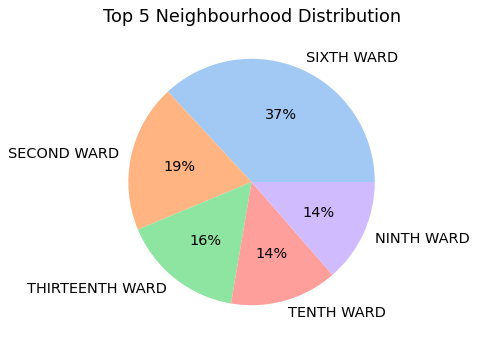

In [30]:
# Count the occurrences of each neighborhood and select the top 5
top_5_neighbourhoods = df['neighbourhood'].value_counts().iloc[:5]

# Create a color palette using seaborn
colors = sns.color_palette('pastel', n_colors=len(top_5_neighbourhoods))

# Plot the pie chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
ax.pie(
    top_5_neighbourhoods, 
    labels=top_5_neighbourhoods.index, 
    autopct='%1.0f%%', 
    startangle=360, 
    colors=colors, 
    textprops={'fontsize': 13}
)
ax.set_title('Top 5 Neighbourhood Distribution', fontsize=16)
plt.show()

#### Minimun nights

In [31]:
df['minimum_nights'].value_counts()

minimum_nights
1     165
2      75
3      32
30     10
7       8
4       8
18      7
14      7
5       5
13      4
10      2
15      1
89      1
6       1
28      1
25      1
Name: count, dtype: int64

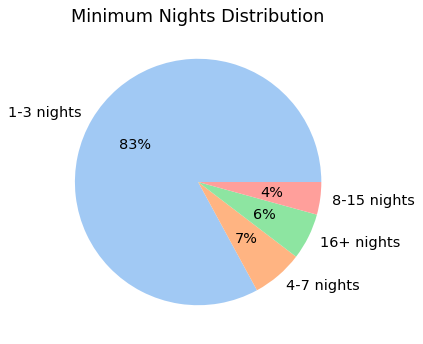

In [32]:
# Create categories for minimum nights
bins = [0, 3, 7, 15, float('inf')]  # Define ranges
labels = ['1-3 nights', '4-7 nights', '8-15 nights', '16+ nights']
df['nights_category'] = pd.cut(df['minimum_nights'], bins=bins, labels=labels)

# Count the occurrences in each category
nights_counts = df['nights_category'].value_counts()

# Create a color palette using seaborn
colors = sns.color_palette('pastel', n_colors=len(nights_counts))

# Plot the pie chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
ax.pie(
    nights_counts, 
    labels=nights_counts.index, 
    autopct='%1.0f%%', 
    startangle=360, 
    colors=colors, 
    textprops={'fontsize': 13}
)
ax.set_title('Minimum Nights Distribution', fontsize=16)
plt.show()

#### Number of reviews

In [33]:
df['number_of_reviews'].value_counts()

number_of_reviews
0     28
1     13
4     12
6     12
7     10
      ..
59     1
82     1
35     1
52     1
32     1
Name: count, Length: 135, dtype: int64

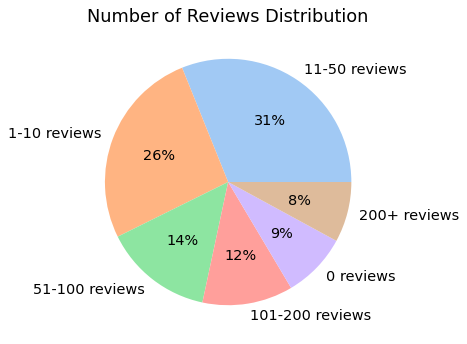

In [34]:
# Create categories for the number of reviews
bins = [-1, 0, 10, 50, 100, 200, float('inf')]  # Adjust bins to remove duplicate edges
labels = ['0 reviews', '1-10 reviews', '11-50 reviews', '51-100 reviews', '101-200 reviews', '200+ reviews']
df['reviews_category'] = pd.cut(df['number_of_reviews'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each category
reviews_counts = df['reviews_category'].value_counts()

# Create a color palette using seaborn
colors = sns.color_palette('pastel', n_colors=len(reviews_counts))

# Plot the pie chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
ax.pie(
    reviews_counts, 
    labels=reviews_counts.index, 
    autopct='%1.0f%%', 
    startangle=360, 
    colors=colors, 
    textprops={'fontsize': 13}
)
ax.set_title('Number of Reviews Distribution', fontsize=16)
plt.show()

#### Availability_365

In [35]:
df['availability_365'].value_counts()

availability_365
358    5
364    5
339    4
267    4
357    4
      ..
237    1
183    1
343    1
171    1
254    1
Name: count, Length: 198, dtype: int64

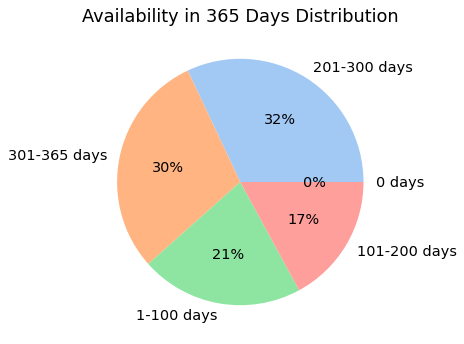

In [36]:
# Create categories for availability
bins = [-1, 0, 100, 200, 300, 365]  # Define ranges
labels = ['0 days', '1-100 days', '101-200 days', '201-300 days', '301-365 days']
df['availability_category'] = pd.cut(df['availability_365'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each category
availability_counts = df['availability_category'].value_counts()

# Create a color palette using seaborn
colors = sns.color_palette('pastel', n_colors=len(availability_counts))

# Plot the pie chart
fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
ax.pie(
    availability_counts, 
    labels=availability_counts.index, 
    autopct='%1.0f%%', 
    startangle=360, 
    colors=colors, 
    textprops={'fontsize': 13}
)
ax.set_title('Availability in 365 Days Distribution', fontsize=16)
plt.show()

### Model Training

In [37]:
df = df[features]
df.head()

,room_type,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,availability_365,price
0,Private room,FOURTEENTH WARD,42.66719,-73.81580,1,250,1.93,255,1.698970
1,Entire home/apt,SIXTH WARD,42.65222,-73.76724,2,300,2.53,361,2.071882
2,Entire home/apt,SECOND WARD,42.64615,-73.75966,1,343,3.13,15,1.954243
3,Entire home/apt,SIXTH WARD,42.65222,-73.76724,2,314,2.89,357,2.079181
4,Private room,TENTH WARD,42.66063,-73.78115,3,18,0.17,179,2.298853


In [38]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
train_dicts[0]

{'room_type': 'Private room',
 'neighbourhood': 'FOURTEENTH WARD',
 'latitude': 42.66719,
 'longitude': -73.8158,
 'minimum_nights': 1,
 'number_of_reviews': 250,
 'reviews_per_month': 1.93,
 'availability_365': 255}

In [39]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'price'
y_train = df[target].values
# y_train = np.log10(y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

rmse = root_mean_squared_error(y_train, y_pred)
print("RMSE: ", rmse)

RMSE:  0.15376140383268486


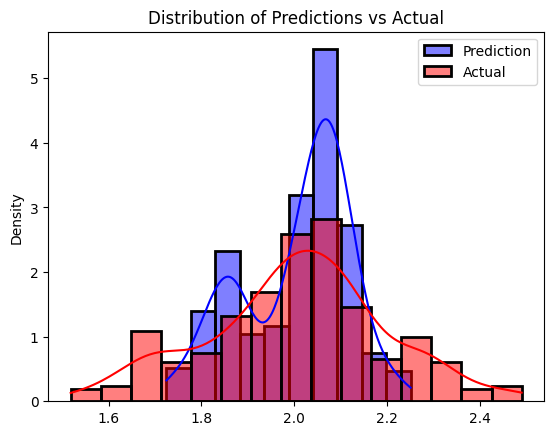

In [40]:
# Plot using sns.histplot()
sns.histplot(y_pred, label='Prediction', kde=True, color='blue', stat='density', linewidth=2)
sns.histplot(y_train, label='Actual', kde=True, color='red', stat='density', linewidth=2)

plt.legend()
plt.title('Distribution of Predictions vs Actual')
plt.show()

In [41]:
print("Intercept: ",lr.intercept_)
print("Coefficients: ",lr.coef_)

Intercept:  -204.2048306076978
Coefficients:  [ 8.08730002e-05  6.56570515e+00  1.00268584e+00 -2.30476118e-03
  1.68315475e-01 -1.39596528e-01  7.14875081e-02 -1.48625148e-01
  2.04438275e-01 -3.89773123e-02 -3.20057035e-03 -4.81662482e-03
  6.26884731e-02 -3.83940785e-04 -1.83925824e-03  3.50491315e-02
 -9.50256543e-02 -5.55951506e-02 -5.39186754e-02 -2.83740670e-04
  2.63593255e-03  1.79110976e-01 -4.43890257e-02 -1.34721950e-01]
